In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("thedevastator/weather-prediction")

print("Path to dataset files:", path)

100%|██████████| 936k/936k [00:00<00:00, 1.38MB/s]

Extracting files...
Path to dataset files: /root/.cache/kagglehub/datasets/thedevastator/weather-prediction/versions/2


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

df = pd.read_csv("weather_prediction_dataset.csv")

print("Shape:", df.shape)
print("First 10 columns:", df.columns[:10].tolist())
df.head()

def plot_target_eda(df, target_col, date_col="DATE"):
    plt.figure(figsize=(10, 4))
    sns.histplot(df[target_col], bins=30, kde=True, color="coral")
    plt.title(f"Distribution of target: {target_col}")
    plt.xlabel(target_col)
    plt.ylabel("Count")
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(12, 4))
    if date_col in df.columns:
        date_vals = pd.to_datetime(df[date_col], format="%Y%m%d", errors="coerce")
        plt.plot(date_vals, df[target_col], label=target_col)
        plt.xlabel("Date")
    else:
        plt.plot(df[target_col].reset_index(drop=True), label=target_col)
        plt.xlabel("Observation index")
    plt.ylabel(target_col)
    plt.title(f"{target_col} over time")
    plt.legend()
    plt.tight_layout()
    plt.show()


Shape: (3654, 165)
First 10 columns: ['DATE', 'MONTH', 'BASEL_cloud_cover', 'BASEL_humidity', 'BASEL_pressure', 'BASEL_global_radiation', 'BASEL_precipitation', 'BASEL_sunshine', 'BASEL_temp_mean', 'BASEL_temp_min']


In [ ]:
def prepare_rf_data(df, target_col, date_col="DATE", test_size=0.2):
    work = df.copy()

    if date_col in work.columns:
        work[date_col] = pd.to_datetime(work[date_col], format="%Y%m%d", errors="coerce")
        work = work.dropna(subset=[date_col])
        work = work.sort_values(date_col)
        date_index = work[date_col].reset_index(drop=True)
    else:
        date_index = pd.RangeIndex(len(work))

    work[target_col] = pd.to_numeric(work[target_col], errors="coerce")

    numeric_cols = work.select_dtypes(include=[np.number]).columns
    cat_cols = work.select_dtypes(include=["object", "category", "bool"]).columns

    work[numeric_cols] = work[numeric_cols].interpolate(limit_direction="both")
    work[numeric_cols] = work[numeric_cols].fillna(work[numeric_cols].median())

    for col in cat_cols:
        work[col] = work[col].fillna(work[col].mode().iloc[0])

    model_df = work.copy()
    if date_col in model_df.columns:
        model_df = model_df.drop(columns=[date_col])

    model_df = pd.get_dummies(model_df, columns=cat_cols, drop_first=True)

    model_df = model_df.dropna(subset=[target_col])

    y = model_df[target_col].values.astype("float32")
    X = model_df.drop(columns=[target_col]).values.astype("float32")

    n = len(X)
    split_idx = int(n * (1 - test_size))

    X_train, X_test = X[:split_idx], X[split_idx:]
    y_train, y_test = y[:split_idx], y[split_idx:]
    date_train, date_test = date_index.iloc[:split_idx], date_index.iloc[split_idx:]

    print(f"Target: {target_col}")
    print(f"Train size: {X_train.shape[0]}, Test size: {X_test.shape[0]}")
    print(f"Number of features: {X_train.shape[1]}")

    return {
        "X_train": X_train,
        "X_test": X_test,
        "y_train": y_train,
        "y_test": y_test,
        "date_train": date_train,
        "date_test": date_test,
    }


In [ ]:
def plot_predictions(date_test, y_true, y_pred, target_col):
    # Time series
    plt.figure(figsize=(12, 4))
    plt.plot(date_test, y_true, label="Actual", color="black")
    plt.plot(date_test, y_pred, label="Predicted", color="teal")
    plt.title(f"Actual vs predicted {target_col} (Random Forest)")
    plt.xlabel("Date")
    plt.ylabel(target_col)
    plt.legend()
    plt.tight_layout()
    plt.show()

    # Scatter
    plt.figure(figsize=(5, 5))
    plt.scatter(y_true, y_pred, alpha=0.6)
    min_val = min(y_true.min(), y_pred.min())
    max_val = max(y_true.max(), y_pred.max())
    plt.plot([min_val, max_val], [min_val, max_val], "r--")
    plt.xlabel("Actual")
    plt.ylabel("Predicted")
    plt.title(f"Predicted vs Actual ({target_col}) - Random Forest")
    plt.tight_layout()
    plt.show()

In [ ]:
def run_rf_for_target(df, target_col, date_col="DATE"):
    print("=" * 80)
    print(f"Running Random Forest regression for target: {target_col}")
    print("=" * 80)

    # EDA
    plot_target_eda(df, target_col, date_col=date_col)

    # Prepare data
    data = prepare_rf_data(df, target_col, date_col=date_col, test_size=0.2)

    X_train = data["X_train"]
    X_test = data["X_test"]
    y_train = data["y_train"]
    y_test = data["y_test"]
    date_test = data["date_test"]

    # Build Random Forest model
    rf = RandomForestRegressor(
        n_estimators=200,
        max_depth=None,
        random_state=42,
        n_jobs=-1
    )

    # Train
    rf.fit(X_train, y_train)

    # Predict
    y_pred = rf.predict(X_test)

    # Metrics
    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)

    print(f"Results for {target_col} (Random Forest):")
    print(f"  MAE  = {mae:.3f}")
    print(f"  RMSE = {rmse:.3f}")
    print(f"  R^2  = {r2:.4f}")

    # Plots
    plot_predictions(date_test, y_test, y_pred, target_col)

    return {
        "model": rf,
        "metrics": {"MAE": mae, "RMSE": rmse, "R2": r2},
        "y_test": y_test,
        "y_pred": y_pred,
        "date_test": date_test,
    }

Running Random Forest regression for target: BASEL_temp_mean


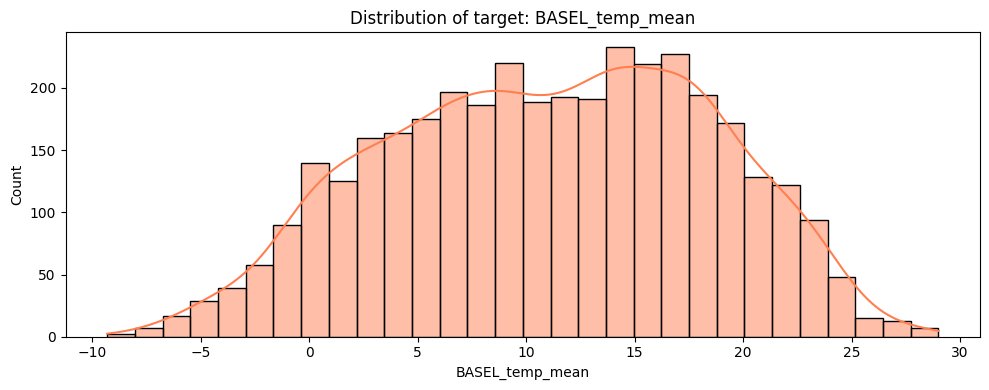

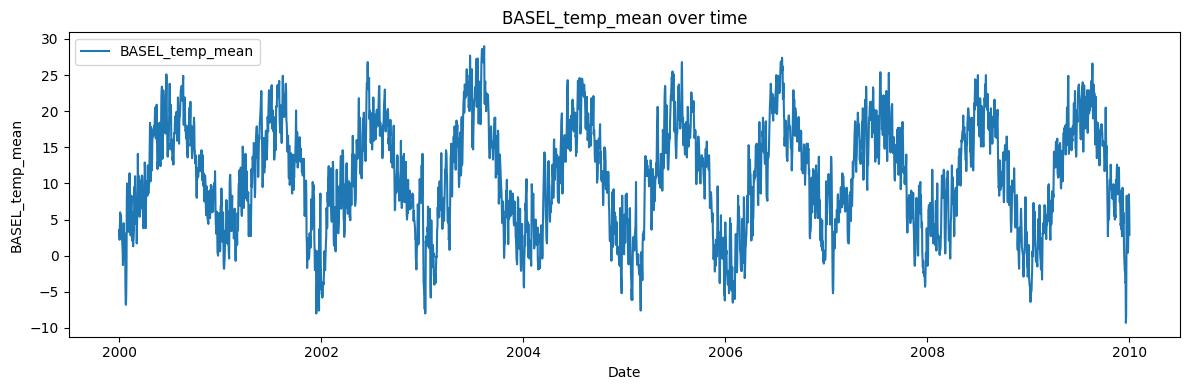

Target: BASEL_temp_mean
Train size: 2923, Test size: 731
Number of features: 163
Results for BASEL_temp_mean (Random Forest):
  MAE  = 0.439
  RMSE = 0.566
  R^2  = 0.9941


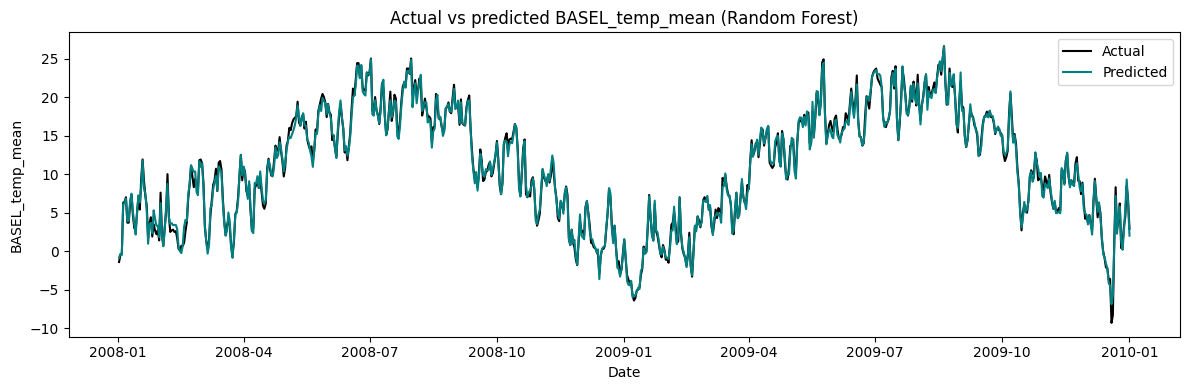

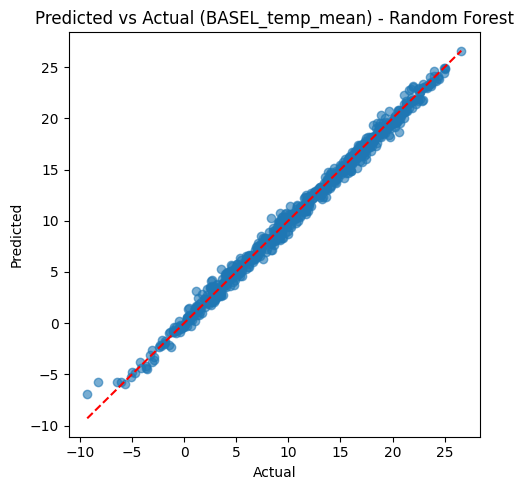

Running Random Forest regression for target: ROMA_temp_mean


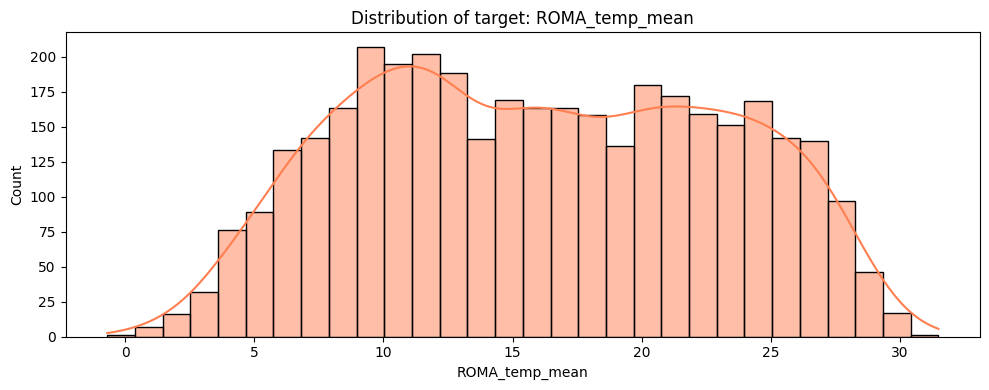

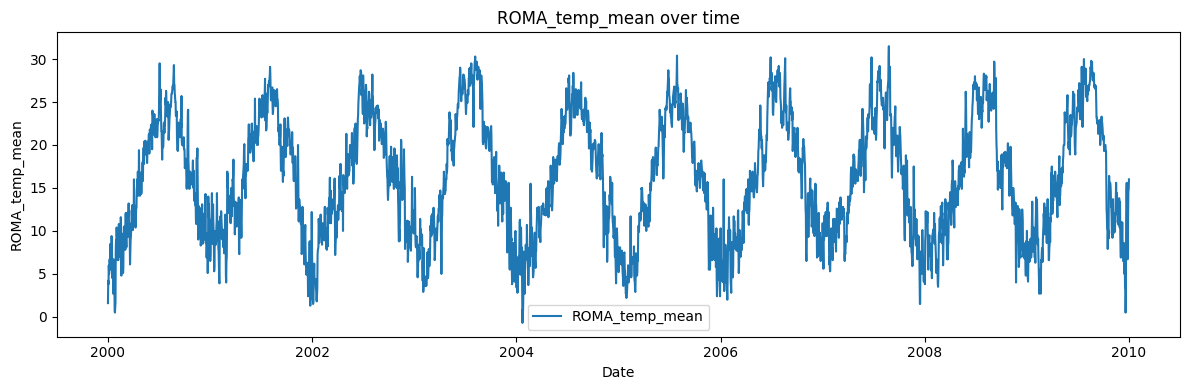

Target: ROMA_temp_mean
Train size: 2923, Test size: 731
Number of features: 163
Results for ROMA_temp_mean (Random Forest):
  MAE  = 0.126
  RMSE = 0.254
  R^2  = 0.9987


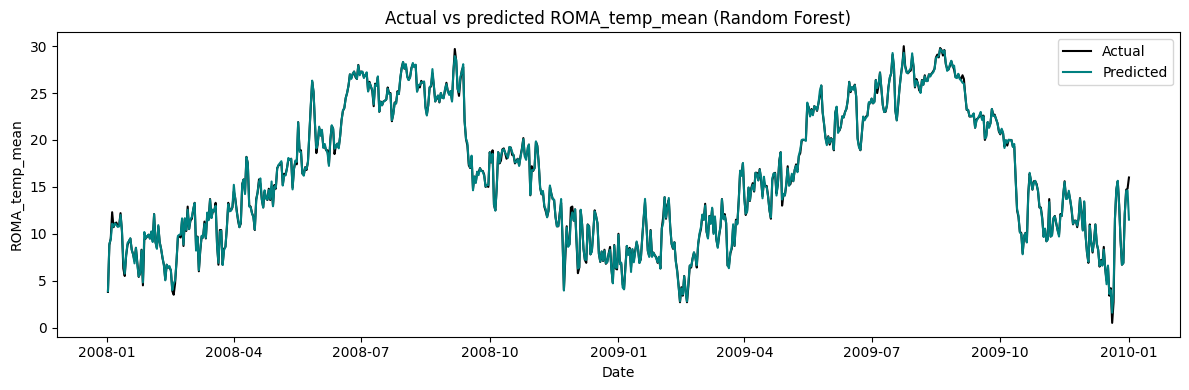

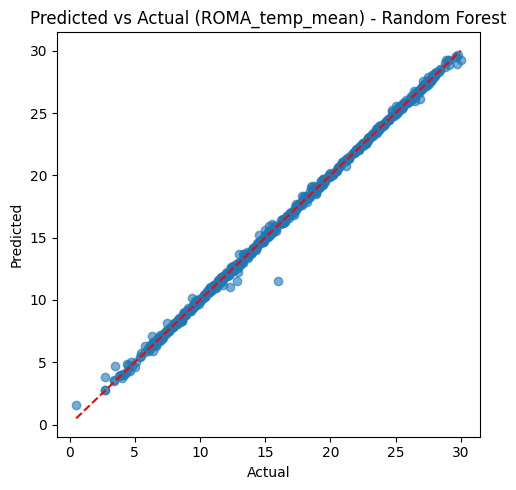

In [ ]:
results_basel_rf = run_rf_for_target(df, target_col="BASEL_temp_mean", date_col="DATE")

results_roma_rf = run_rf_for_target(df, target_col="ROMA_temp_mean", date_col="DATE")